In [1]:
from pathlib import Path
from tkinter import Tk
from tkinter.filedialog import askopenfilenames
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.ticker as plticker

idx = pd.IndexSlice

# Define automatic naming format from file_paths
def get_name(file_path,data_type):
    name = file_path.stem.split("_")
    if data_type == 'avg':
        name = name[3]+'_'+name[4]
    elif data_type == 'indv':
        name = name[3]+'_'+name[5]
        
    return name

# Define axis labels based on parameter
def gen_param_label(param):
    param_dict = {
        'mAh':'[mAh]',
        'mass':'[mAh/g]',
        'areal':r'$\mathrm{[mAh/cm^2]}$',
        'volume':r'$\mathrm{[mAh/cm^3]$'}
    
    return param_dict[param]

In [2]:
# Open file dialog
root = Tk()
root.attributes("-topmost", True)
root.withdraw()  # stops root window from appearing
file_paths = askopenfilenames(title="Select files",
                              filetypes=[("Comma-separated values", "*.csv")])  # "Open" dialog box and return the selected path

# Convert filepaths to pathlib format
filez = []
for file in file_paths:
    file = Path(file)
    filez.append(file)
    
file_paths = filez

In [3]:
# Generate 'names' and 'param' dictionaries from file_paths
# read_csv to dataframe
names={}
params = {}
df=[]
for i, file_path in enumerate(file_paths):
    if 'avg' in file_paths[i].stem:
        data_type = 'avg'
    else:
        data_type = 'indv'
    
    name = get_name(file_paths[i],data_type)
    names[i] = name
    
    df_imp = pd.read_csv(file_paths[i],header=[1,2],index_col=[0,1])
    df_imp = pd.concat([df_imp], axis=1, keys=[i])
    
    df.append(df_imp)

    params[i] = df_imp.columns.get_level_values(1)[1]
      
df = pd.concat(df, axis=1)
df.sort_index(inplace=True)

for cell in names:
    print(cell, '->', names[cell], '->', params[cell])

0 -> 201027_SL -> mass
1 -> 201027_SP -> mass


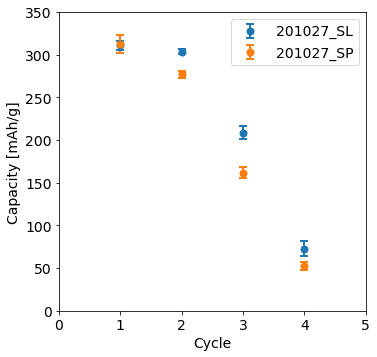

In [15]:
# Make list of cycles to plot
#cycles = df.index.unique(level=1).tolist()
posCC = [4,9,14,19]
negCC = [23,28,33]
negCV = [24,29,34]
step_filt = [posCC]
upper = len(step_filt[0])+1

# Create figure and axes
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(5.5, 5.5))

# Params
ax.set_ylim(ymin=0, ymax=350)
ax.set_xlim(xmin=0, xmax=upper)

# Plot cycle data
for filt in step_filt:
    for cell in names:
        df_plot = df.loc[idx[filt,:],idx[cell,params[cell],'cap']]
        cyc_idx = list(range(1,len(df_plot)+1))

        if 'cap_std' in df[cell][params[cell]].columns:
            yerr = df.loc[idx[filt,:],idx[cell,params[cell],'cap_std']]
            plt.errorbar(cyc_idx,
                         df_plot,
                         yerr=yerr,
                         fmt='o',
                         capsize=4, 
                         elinewidth=2,
                         markeredgewidth=2,
                         label = names[cell])    
        else:
            plt.scatter(cyc_idx,df_plot,label = names[cell])
        
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
    
plt.xlabel("Cycle")
plt.ylabel('Capacity '+gen_param_label(params[0]))
plt.legend(loc='best')

plt.savefig(file_paths[cell].parent.joinpath('{}_{}.svg'.format('cycles_mass',names[cell])),
            format='svg', 
            dpi=600, 
            bbox_inches = 'tight')
plt.show()